# Setup inicial

In [2]:
# ============================================================================
# NOTEBOOK: 05_modeling_wGPU.ipynb
# Modelagem com aceleração GPU e otimização de hiperparâmetros
# ============================================================================

# ============================================================================
# SETUP INICIAL
# ============================================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
import lightgbm as lgb
import xgboost as xgb
from catboost import CatBoostClassifier
import optuna
from optuna.visualization import plot_optimization_history, plot_param_importances
import joblib
import warnings
warnings.filterwarnings('ignore')

# Configuracoes
plt.style.use('seaborn-v0_8-darkgrid')
RANDOM_STATE = 42
N_FOLDS = 5

# Carregar dados processados
train = pd.read_csv('../data/processed/train_processed.csv')
test = pd.read_csv('../data/processed/test_processed.csv')

print(f"Train shape: {train.shape}")
print(f"Test shape: {test.shape}")

# Separar features e target
y = train['y']
X = train.drop(['y', 'id'], axis=1, errors='ignore')
X_test = test.drop('id', axis=1, errors='ignore')

print(f"\nX shape: {X.shape}")
print(f"y shape: {y.shape}")
print(f"X_test shape: {X_test.shape}")

# Verificar desbalanceamento
print("\nDistribuicao do target:")
print(y.value_counts())
print(y.value_counts(normalize=True))

# Calcular scale_pos_weight para modelos tree-based
scale_pos_weight = (y == 0).sum() / (y == 1).sum()
print(f"\nScale pos weight: {scale_pos_weight:.2f}")

Train shape: (750000, 69)
Test shape: (250000, 68)

X shape: (750000, 67)
y shape: (750000,)
X_test shape: (250000, 67)

Distribuicao do target:
y
0    659512
1     90488
Name: count, dtype: int64
y
0    0.879349
1    0.120651
Name: proportion, dtype: float64

Scale pos weight: 7.29


# Análise básica dos modelos

## Stratified K-Fold

In [3]:
print("\n" + "="*70)
print("CONFIGURACAO DA VALIDACAO CRUZADA")
print("="*70)

# Stratified K-Fold para manter proporcao das classes
skf = StratifiedKFold(n_splits=N_FOLDS, shuffle=True, random_state=RANDOM_STATE)

def evaluate_model_cv(model, X, y, cv=skf):
    """
    Avalia modelo usando cross-validation
    Retorna media e desvio padrao do AUC-ROC
    """
    scores = []
    
    for fold, (train_idx, val_idx) in enumerate(cv.split(X, y), 1):
        X_train_fold, X_val_fold = X.iloc[train_idx], X.iloc[val_idx]
        y_train_fold, y_val_fold = y.iloc[train_idx], y.iloc[val_idx]
        
        # Treinar
        model.fit(X_train_fold, y_train_fold)
        
        # Prever probabilidades
        y_pred_proba = model.predict_proba(X_val_fold)[:, 1]
        
        # Calcular AUC
        auc = roc_auc_score(y_val_fold, y_pred_proba)
        scores.append(auc)
        
        print(f"Fold {fold} AUC: {auc:.5f}")
    
    mean_auc = np.mean(scores)
    std_auc = np.std(scores)
    
    print("="*50)
    print(f"Mean AUC: {mean_auc:.5f} (+/- {std_auc:.5f})")
    print("="*50)
    
    return mean_auc, std_auc, scores

print("Validacao cruzada configurada")


CONFIGURACAO DA VALIDACAO CRUZADA
Validacao cruzada configurada


## Baseline - Regressão Logística

In [4]:
print("\n" + "="*70)
print("MODELO BASELINE: LOGISTIC REGRESSION")
print("="*70 + "\n")

# Modelo com class_weight para lidar com desbalanceamento
lr_model = LogisticRegression(
    random_state=RANDOM_STATE,
    max_iter=1000,
    class_weight='balanced',
    solver='lbfgs'
)

# Avaliar com CV
lr_mean_auc, lr_std_auc, lr_scores = evaluate_model_cv(lr_model, X, y)

# Salvar resultado
baseline_results = {
    'model': 'Logistic Regression',
    'mean_auc': lr_mean_auc,
    'std_auc': lr_std_auc,
    'scores': lr_scores
}


MODELO BASELINE: LOGISTIC REGRESSION

Fold 1 AUC: 0.93547
Fold 2 AUC: 0.93557
Fold 3 AUC: 0.93407
Fold 4 AUC: 0.93658
Fold 5 AUC: 0.93603
Mean AUC: 0.93554 (+/- 0.00084)


## LighGBM

In [5]:
print("\n" + "="*70)
print("MODELO: LIGHTGBM (GPU)")
print("="*70 + "\n")

lgb_params = {
    'objective': 'binary',
    'metric': 'auc',
    'boosting_type': 'gbdt',
    'device': 'gpu',
    'gpu_platform_id': 0,
    'gpu_device_id': 0,
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.8,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'max_depth': -1,
    'min_child_samples': 20,
    'scale_pos_weight': scale_pos_weight,
    'random_state': RANDOM_STATE,
    'verbose': -1
}

lgb_scores = []
lgb_models = []

for fold, (train_idx, val_idx) in enumerate(skf.split(X, y), 1):
    print(f"\nTraining Fold {fold}/{N_FOLDS}")
    
    X_train_fold, X_val_fold = X.iloc[train_idx], X.iloc[val_idx]
    y_train_fold, y_val_fold = y.iloc[train_idx], y.iloc[val_idx]
    
    # Criar datasets LightGBM
    train_data = lgb.Dataset(X_train_fold, label=y_train_fold)
    val_data = lgb.Dataset(X_val_fold, label=y_val_fold, reference=train_data)
    
    # Treinar
    model = lgb.train(
        lgb_params,
        train_data,
        num_boost_round=1000,
        valid_sets=[train_data, val_data],
        valid_names=['train', 'valid'],
        callbacks=[
            lgb.early_stopping(stopping_rounds=50, verbose=False),
            lgb.log_evaluation(period=100)
        ]
    )
    
    # Prever
    y_pred_proba = model.predict(X_val_fold, num_iteration=model.best_iteration)
    auc = roc_auc_score(y_val_fold, y_pred_proba)
    
    lgb_scores.append(auc)
    lgb_models.append(model)
    
    print(f"Fold {fold} AUC: {auc:.5f}")

lgb_mean_auc = np.mean(lgb_scores)
lgb_std_auc = np.std(lgb_scores)

print(f"\n{'='*50}")
print(f"LightGBM (GPU) Mean AUC: {lgb_mean_auc:.5f} (+/- {lgb_std_auc:.5f})")
print(f"{'='*50}\n")

lgb_results = {
    'model': 'LightGBM (GPU)',
    'mean_auc': lgb_mean_auc,
    'std_auc': lgb_std_auc,
    'scores': lgb_scores,
    'models': lgb_models
}


MODELO: LIGHTGBM (GPU)


Training Fold 1/5
[100]	train's auc: 0.961649	valid's auc: 0.961695
[200]	train's auc: 0.965942	valid's auc: 0.965385
[300]	train's auc: 0.967702	valid's auc: 0.966392
[400]	train's auc: 0.968943	valid's auc: 0.967
[500]	train's auc: 0.969939	valid's auc: 0.96738
[600]	train's auc: 0.970843	valid's auc: 0.967652
[700]	train's auc: 0.971651	valid's auc: 0.967882
[800]	train's auc: 0.972342	valid's auc: 0.968015
[900]	train's auc: 0.973114	valid's auc: 0.968222
[1000]	train's auc: 0.973819	valid's auc: 0.968376
Fold 1 AUC: 0.96838

Training Fold 2/5
[100]	train's auc: 0.961997	valid's auc: 0.960551
[200]	train's auc: 0.966303	valid's auc: 0.964301
[300]	train's auc: 0.968022	valid's auc: 0.965334
[400]	train's auc: 0.969136	valid's auc: 0.965768
[500]	train's auc: 0.970223	valid's auc: 0.966292
[600]	train's auc: 0.971133	valid's auc: 0.9666
[700]	train's auc: 0.971982	valid's auc: 0.966883
[800]	train's auc: 0.972689	valid's auc: 0.967055
[900]	train's auc: 0.9

## XGBoost

In [6]:
# ----------------------------------------------------------------------------
# XGBOOST COM GPU
# ----------------------------------------------------------------------------

print("\n" + "="*70)
print("MODELO: XGBOOST (GPU)")
print("="*70 + "\n")

xgb_params = {
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'device': 'cuda',  # Mudanca aqui: usar 'cuda' ou 'cuda:0'
    'tree_method': 'hist',  # 'hist' funciona em GPU automaticamente
    'max_depth': 6,
    'learning_rate': 0.05,
    'n_estimators': 1000,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'scale_pos_weight': scale_pos_weight,
    'random_state': RANDOM_STATE,
    'early_stopping_rounds': 50,
    'n_jobs': -1
}

xgb_scores = []
xgb_models = []

for fold, (train_idx, val_idx) in enumerate(skf.split(X, y), 1):
    print(f"\nTraining Fold {fold}/{N_FOLDS}")
    
    X_train_fold, X_val_fold = X.iloc[train_idx], X.iloc[val_idx]
    y_train_fold, y_val_fold = y.iloc[train_idx], y.iloc[val_idx]
    
    model = xgb.XGBClassifier(**xgb_params)
    
    # Treinar
    model.fit(
        X_train_fold, y_train_fold,
        eval_set=[(X_val_fold, y_val_fold)],
        verbose=100
    )
    
    # Prever
    y_pred_proba = model.predict_proba(X_val_fold)[:, 1]
    auc = roc_auc_score(y_val_fold, y_pred_proba)
    
    xgb_scores.append(auc)
    xgb_models.append(model)
    
    print(f"Fold {fold} AUC: {auc:.5f}")

xgb_mean_auc = np.mean(xgb_scores)
xgb_std_auc = np.std(xgb_scores)

print(f"\n{'='*50}")
print(f"XGBoost (GPU) Mean AUC: {xgb_mean_auc:.5f} (+/- {xgb_std_auc:.5f})")
print(f"{'='*50}\n")

xgb_results = {
    'model': 'XGBoost (GPU)',
    'mean_auc': xgb_mean_auc,
    'std_auc': xgb_std_auc,
    'scores': xgb_scores,
    'models': xgb_models
}


MODELO: XGBOOST (GPU)


Training Fold 1/5
[0]	validation_0-auc:0.93971
[100]	validation_0-auc:0.95994
[200]	validation_0-auc:0.96413
[300]	validation_0-auc:0.96560
[400]	validation_0-auc:0.96639
[500]	validation_0-auc:0.96685
[600]	validation_0-auc:0.96722
[700]	validation_0-auc:0.96747
[800]	validation_0-auc:0.96765
[900]	validation_0-auc:0.96779
[999]	validation_0-auc:0.96791
Fold 1 AUC: 0.96791

Training Fold 2/5
[0]	validation_0-auc:0.93929
[100]	validation_0-auc:0.95905
[200]	validation_0-auc:0.96312
[300]	validation_0-auc:0.96452
[400]	validation_0-auc:0.96528
[500]	validation_0-auc:0.96576
[600]	validation_0-auc:0.96610
[700]	validation_0-auc:0.96631
[800]	validation_0-auc:0.96646
[900]	validation_0-auc:0.96659
[999]	validation_0-auc:0.96666
Fold 2 AUC: 0.96667

Training Fold 3/5
[0]	validation_0-auc:0.93860
[100]	validation_0-auc:0.95894
[200]	validation_0-auc:0.96328
[300]	validation_0-auc:0.96484
[400]	validation_0-auc:0.96561
[500]	validation_0-auc:0.96601
[600]	validation_

## Catboost

In [7]:
print("\n" + "="*70)
print("MODELO: CATBOOST (GPU)")
print("="*70 + "\n")

cat_params = {
    'iterations': 1000,
    'learning_rate': 0.05,
    'depth': 6,
    'l2_leaf_reg': 3,
    'loss_function': 'Logloss',
    'eval_metric': 'Logloss',
    'task_type': 'GPU',
    'devices': '0',
    'random_seed': RANDOM_STATE,
    'verbose': 100,
    'early_stopping_rounds': 50,
    'scale_pos_weight': scale_pos_weight
}

cat_scores = []
cat_models = []

for fold, (train_idx, val_idx) in enumerate(skf.split(X, y), 1):
    print(f"\nTraining Fold {fold}/{N_FOLDS}")
    
    X_train_fold, X_val_fold = X.iloc[train_idx], X.iloc[val_idx]
    y_train_fold, y_val_fold = y.iloc[train_idx], y.iloc[val_idx]
    
    model = CatBoostClassifier(**cat_params)
    
    # Treinar
    model.fit(
        X_train_fold, y_train_fold,
        eval_set=(X_val_fold, y_val_fold),
        verbose=False
    )
    
    # Prever e calcular AUC manualmente
    y_pred_proba = model.predict_proba(X_val_fold)[:, 1]
    auc = roc_auc_score(y_val_fold, y_pred_proba)
    
    cat_scores.append(auc)
    cat_models.append(model)
    
    print(f"Fold {fold} AUC: {auc:.5f}")

cat_mean_auc = np.mean(cat_scores)
cat_std_auc = np.std(cat_scores)

print(f"\n{'='*50}")
print(f"CatBoost (GPU) Mean AUC: {cat_mean_auc:.5f} (+/- {cat_std_auc:.5f})")
print(f"{'='*50}\n")

cat_results = {
    'model': 'CatBoost (GPU)',
    'mean_auc': cat_mean_auc,
    'std_auc': cat_std_auc,
    'scores': cat_scores,
    'models': cat_models
}


MODELO: CATBOOST (GPU)


Training Fold 1/5
Fold 1 AUC: 0.96597

Training Fold 2/5
Fold 2 AUC: 0.96489

Training Fold 3/5
Fold 3 AUC: 0.96491

Training Fold 4/5
Fold 4 AUC: 0.96578

Training Fold 5/5
Fold 5 AUC: 0.96527

CatBoost (GPU) Mean AUC: 0.96536 (+/- 0.00044)



# Análise resultados parciais

## Análise de feature importance


ANALISE DE FEATURE IMPORTANCE


Top 30 Features:
                         feature    importance
3                       duration  5.067232e+06
65               contact_unknown  3.047959e+05
21                is_high_season  2.993752e+05
58                 month_encoded  2.795821e+05
8              historico_sucesso  2.580945e+05
2                            day  1.844792e+05
56            balance_loan_ratio  1.593753e+05
41                   total_loans  1.539769e+05
39               balance_per_age  1.418195e+05
5                          pdays  1.288546e+05
0                            age  9.318724e+04
42                   sem_dividas  8.997337e+04
12         has_effective_contact  8.918376e+04
59                   job_encoded  8.509995e+04
53  campaign_success_interaction  6.081514e+04
40                   balance_log  5.463271e+04
23                       quarter  5.411971e+04
1                        balance  5.155413e+04
52             age_balance_ratio  4.859038e+04
55        

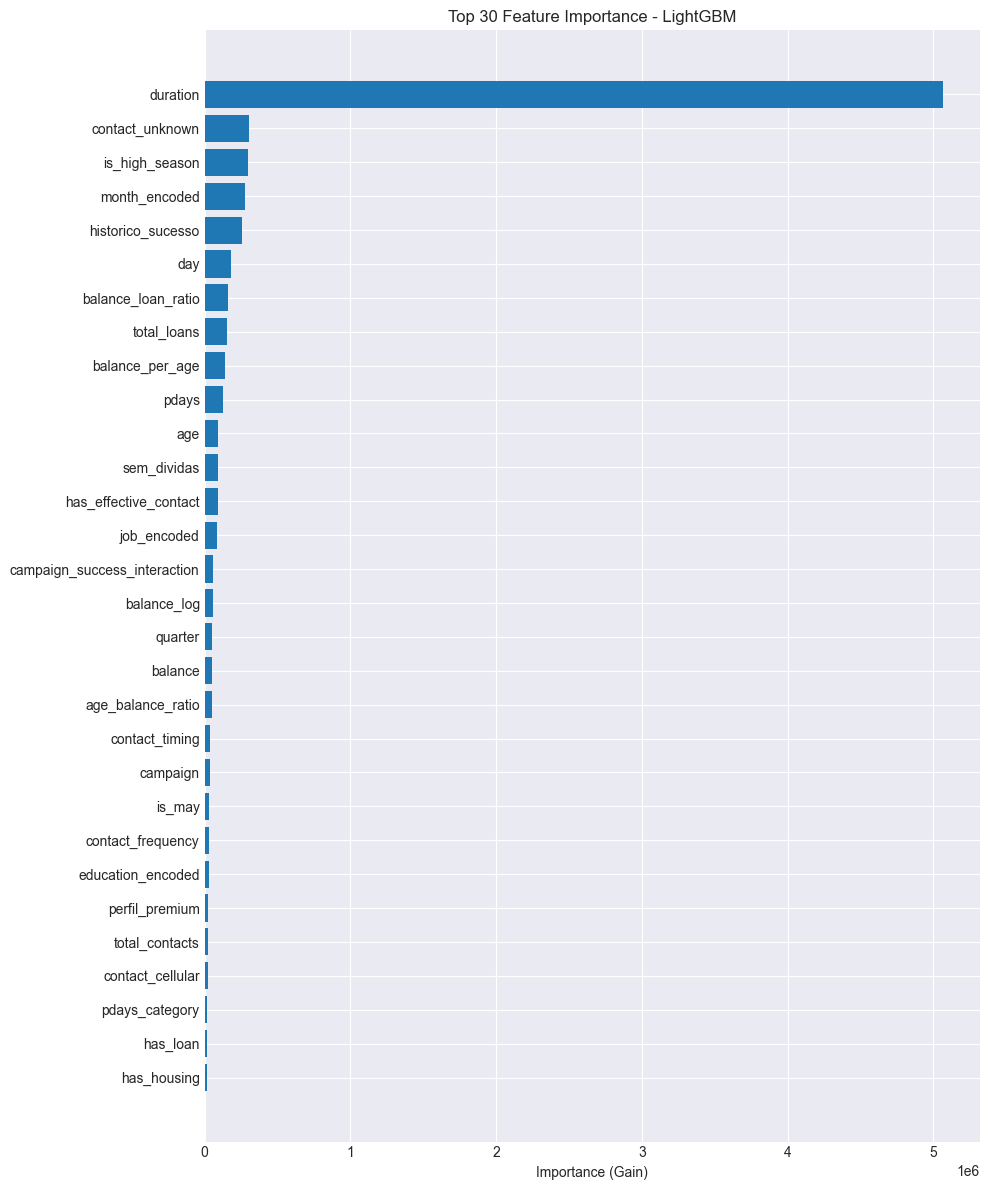

In [8]:
print("\n" + "="*70)
print("ANALISE DE FEATURE IMPORTANCE")
print("="*70 + "\n")

# Usar o primeiro modelo LightGBM para feature importance
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': lgb_models[0].feature_importance(importance_type='gain')
})

feature_importance = feature_importance.sort_values('importance', ascending=False)
print("\nTop 30 Features:")
print(feature_importance.head(30))

# Visualizar top 30 features
plt.figure(figsize=(10, 12))
plt.barh(range(30), feature_importance['importance'].head(30))
plt.yticks(range(30), feature_importance['feature'].head(30))
plt.xlabel('Importance (Gain)')
plt.title('Top 30 Feature Importance - LightGBM')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

# Salvar feature importance
feature_importance.to_csv('../data/processed/feature_importance_gpu.csv', index=False)

## Comparação dos modelos


COMPARACAO DE MODELOS BASICOS

                 Model  Mean AUC   Std AUC
1       LightGBM (GPU)  0.967808  0.000443
2        XGBoost (GPU)  0.967302  0.000531
3       CatBoost (GPU)  0.965365  0.000442
0  Logistic Regression  0.935543  0.000837


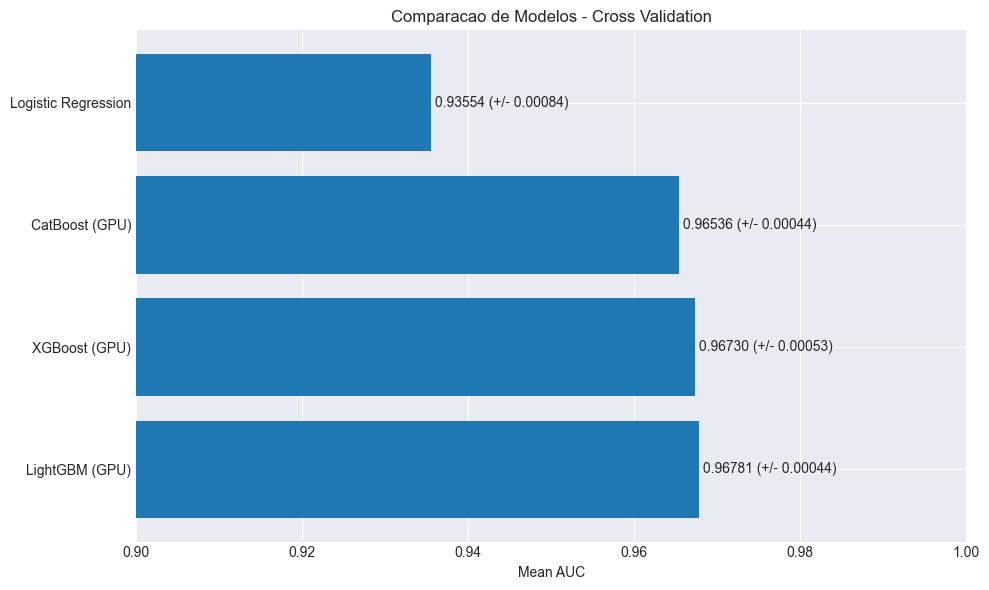

In [9]:
print("\n" + "="*70)
print("COMPARACAO DE MODELOS BASICOS")
print("="*70 + "\n")

results_comparison = pd.DataFrame([
    {'Model': 'Logistic Regression', 'Mean AUC': lr_mean_auc, 'Std AUC': lr_std_auc},
    {'Model': 'LightGBM (GPU)', 'Mean AUC': lgb_mean_auc, 'Std AUC': lgb_std_auc},
    {'Model': 'XGBoost (GPU)', 'Mean AUC': xgb_mean_auc, 'Std AUC': xgb_std_auc},
    {'Model': 'CatBoost (GPU)', 'Mean AUC': cat_mean_auc, 'Std AUC': cat_std_auc}
])

results_comparison = results_comparison.sort_values('Mean AUC', ascending=False)
print(results_comparison)

# Visualizar comparacao
plt.figure(figsize=(10, 6))
plt.barh(results_comparison['Model'], results_comparison['Mean AUC'])
plt.xlabel('Mean AUC')
plt.title('Comparacao de Modelos - Cross Validation')
plt.xlim(0.9, 1.0)
for i, (auc, std) in enumerate(zip(results_comparison['Mean AUC'], results_comparison['Std AUC'])):
    plt.text(auc, i, f' {auc:.5f} (+/- {std:.5f})', va='center')
plt.tight_layout()
plt.show()

# Avaliando hiperparâmetros

In [10]:
print("\n" + "="*70)
print("HYPERPARAMETER TUNING COM OPTUNA")
print("="*70 + "\n")


HYPERPARAMETER TUNING COM OPTUNA



## Tuning LightGBM

In [11]:
print("="*70)
print("HYPERPARAMETER TUNING - LIGHTGBM (GPU)")
print("="*70 + "\n")

def objective_lgb(trial):
    """Funcao objetivo para Optuna - LightGBM"""
    
    params = {
        'objective': 'binary',
        'metric': 'auc',
        'boosting_type': 'gbdt',
        'device': 'gpu',
        'gpu_platform_id': 0,
        'gpu_device_id': 0,
        
        # Hiperparametros para otimizar
        'num_leaves': trial.suggest_int('num_leaves', 20, 100),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1),
        'feature_fraction': trial.suggest_float('feature_fraction', 0.6, 1.0),
        'bagging_fraction': trial.suggest_float('bagging_fraction', 0.6, 1.0),
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 7),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 50),
        'max_depth': trial.suggest_int('max_depth', 3, 12),
        
        'scale_pos_weight': scale_pos_weight,
        'random_state': RANDOM_STATE,
        'verbose': -1
    }
    
    cv_scores = []
    
    for train_idx, val_idx in skf.split(X, y):
        X_train_fold = X.iloc[train_idx]
        X_val_fold = X.iloc[val_idx]
        y_train_fold = y.iloc[train_idx]
        y_val_fold = y.iloc[val_idx]
        
        train_data = lgb.Dataset(X_train_fold, label=y_train_fold)
        val_data = lgb.Dataset(X_val_fold, label=y_val_fold, reference=train_data)
        
        model = lgb.train(
            params,
            train_data,
            num_boost_round=500,
            valid_sets=[val_data],
            callbacks=[lgb.early_stopping(30, verbose=False)]
        )
        
        y_pred = model.predict(X_val_fold, num_iteration=model.best_iteration)
        auc = roc_auc_score(y_val_fold, y_pred)
        cv_scores.append(auc)
    
    return np.mean(cv_scores)

# Rodar otimizacao
print("Iniciando Hyperparameter Tuning LightGBM...")
print("Isso pode levar alguns minutos...\n")

study_lgb = optuna.create_study(direction='maximize', study_name='lgb_gpu_optimization')
study_lgb.optimize(objective_lgb, n_trials=50, show_progress_bar=True)

print("\n" + "="*70)
print("MELHORES HIPERPARAMETROS - LIGHTGBM")
print("="*70)
print(f"Melhor AUC: {study_lgb.best_value:.5f}")
print(f"Melhoria sobre baseline: {study_lgb.best_value - lgb_mean_auc:.5f}")
print("\nMelhores parametros:")
for key, value in study_lgb.best_params.items():
    print(f"  {key}: {value}")

[I 2025-12-11 11:52:55,499] A new study created in memory with name: lgb_gpu_optimization


HYPERPARAMETER TUNING - LIGHTGBM (GPU)

Iniciando Hyperparameter Tuning LightGBM...
Isso pode levar alguns minutos...



  0%|          | 0/50 [00:00<?, ?it/s]

[I 2025-12-11 11:55:26,761] Trial 0 finished with value: 0.9643826909702014 and parameters: {'num_leaves': 20, 'learning_rate': 0.03643605798419975, 'feature_fraction': 0.7124081327509934, 'bagging_fraction': 0.8367946471019627, 'bagging_freq': 4, 'min_child_samples': 28, 'max_depth': 5}. Best is trial 0 with value: 0.9643826909702014.
[I 2025-12-11 11:58:30,895] Trial 1 finished with value: 0.9660517444746549 and parameters: {'num_leaves': 31, 'learning_rate': 0.034406092945318024, 'feature_fraction': 0.8544268503166976, 'bagging_fraction': 0.8591046469373347, 'bagging_freq': 3, 'min_child_samples': 21, 'max_depth': 10}. Best is trial 1 with value: 0.9660517444746549.
[I 2025-12-11 12:00:58,648] Trial 2 finished with value: 0.9670679113367667 and parameters: {'num_leaves': 22, 'learning_rate': 0.09605705587263776, 'feature_fraction': 0.9094913227109334, 'bagging_fraction': 0.8572493706081015, 'bagging_freq': 5, 'min_child_samples': 40, 'max_depth': 10}. Best is trial 2 with value: 0.9

## Tuning XGBoost

In [12]:
print("\n" + "="*70)
print("HYPERPARAMETER TUNING - XGBOOST (GPU)")
print("="*70 + "\n")

def objective_xgb(trial):
    """Funcao objetivo para Optuna - XGBoost"""
    
    params = {
        'objective': 'binary:logistic',
        'eval_metric': 'auc',
        'device': 'cuda',  # Mudanca aqui
        'tree_method': 'hist',
        
        # Hiperparametros para otimizar
        'max_depth': trial.suggest_int('max_depth', 3, 12),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1),
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'gamma': trial.suggest_float('gamma', 0, 0.5),
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 1.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 0, 1.0),
        
        'scale_pos_weight': scale_pos_weight,
        'random_state': RANDOM_STATE,
        'early_stopping_rounds': 30,
        'n_jobs': -1
    }
    
    cv_scores = []
    
    for train_idx, val_idx in skf.split(X, y):
        X_train_fold = X.iloc[train_idx]
        X_val_fold = X.iloc[val_idx]
        y_train_fold = y.iloc[train_idx]
        y_val_fold = y.iloc[val_idx]
        
        model = xgb.XGBClassifier(**params)
        model.fit(
            X_train_fold, y_train_fold,
            eval_set=[(X_val_fold, y_val_fold)],
            verbose=False
        )
        
        y_pred = model.predict_proba(X_val_fold)[:, 1]
        auc = roc_auc_score(y_val_fold, y_pred)
        cv_scores.append(auc)
    
    return np.mean(cv_scores)

# Rodar otimizacao
print("Iniciando Hyperparameter Tuning XGBoost...")
print("Isso pode levar alguns minutos...\n")

study_xgb = optuna.create_study(direction='maximize', study_name='xgb_gpu_optimization')
study_xgb.optimize(objective_xgb, n_trials=50, show_progress_bar=True)

print("\n" + "="*70)
print("MELHORES HIPERPARAMETROS - XGBOOST")
print("="*70)
print(f"Melhor AUC: {study_xgb.best_value:.5f}")
print(f"Melhoria sobre baseline: {study_xgb.best_value - xgb_mean_auc:.5f}")
print("\nMelhores parametros:")
for key, value in study_xgb.best_params.items():
    print(f"  {key}: {value}")

[I 2025-12-11 15:03:12,696] A new study created in memory with name: xgb_gpu_optimization



HYPERPARAMETER TUNING - XGBOOST (GPU)

Iniciando Hyperparameter Tuning XGBoost...
Isso pode levar alguns minutos...



  0%|          | 0/50 [00:00<?, ?it/s]

[I 2025-12-11 15:03:49,416] Trial 0 finished with value: 0.96606642922509 and parameters: {'max_depth': 5, 'learning_rate': 0.037086613200389085, 'n_estimators': 961, 'min_child_weight': 5, 'subsample': 0.6522199829783898, 'colsample_bytree': 0.7797160532119529, 'gamma': 0.2823137682851161, 'reg_alpha': 0.1355835156159756, 'reg_lambda': 0.5445903902763838}. Best is trial 0 with value: 0.96606642922509.
[I 2025-12-11 15:04:18,148] Trial 1 finished with value: 0.9671265957903318 and parameters: {'max_depth': 9, 'learning_rate': 0.04856239912944695, 'n_estimators': 332, 'min_child_weight': 5, 'subsample': 0.7452751799952443, 'colsample_bytree': 0.6104419316866612, 'gamma': 0.15463371764142214, 'reg_alpha': 0.7453907225059894, 'reg_lambda': 0.26895593506818305}. Best is trial 1 with value: 0.9671265957903318.
[I 2025-12-11 15:04:48,268] Trial 2 finished with value: 0.9669236155095904 and parameters: {'max_depth': 11, 'learning_rate': 0.08758705198740836, 'n_estimators': 604, 'min_child_wei

## Tuning Catboost

In [13]:
print("\n" + "="*70)
print("HYPERPARAMETER TUNING - CATBOOST (GPU)")
print("="*70 + "\n")

def objective_cat(trial):
    """Funcao objetivo para Optuna - CatBoost"""
    
    params = {
        'loss_function': 'Logloss',
        'eval_metric': 'Logloss',
        'task_type': 'GPU',
        'devices': '0',
        
        # Hiperparametros para otimizar
        'iterations': trial.suggest_int('iterations', 100, 1000),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1),
        'depth': trial.suggest_int('depth', 4, 10),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1, 10),
        'border_count': trial.suggest_int('border_count', 32, 255),
        'bagging_temperature': trial.suggest_float('bagging_temperature', 0, 1),
        'random_strength': trial.suggest_float('random_strength', 0, 10),
        
        'scale_pos_weight': scale_pos_weight,
        'random_seed': RANDOM_STATE,
        'verbose': False
    }
    
    cv_scores = []
    
    for train_idx, val_idx in skf.split(X, y):
        X_train_fold = X.iloc[train_idx]
        X_val_fold = X.iloc[val_idx]
        y_train_fold = y.iloc[train_idx]
        y_val_fold = y.iloc[val_idx]
        
        model = CatBoostClassifier(**params)
        model.fit(
            X_train_fold, y_train_fold,
            eval_set=(X_val_fold, y_val_fold),
            early_stopping_rounds=30,
            verbose=False
        )
        
        y_pred = model.predict_proba(X_val_fold)[:, 1]
        auc = roc_auc_score(y_val_fold, y_pred)
        cv_scores.append(auc)
    
    return np.mean(cv_scores)

# Rodar otimizacao
print("Iniciando Hyperparameter Tuning CatBoost...")
print("Isso pode levar alguns minutos...\n")

study_cat = optuna.create_study(direction='maximize', study_name='cat_gpu_optimization')
study_cat.optimize(objective_cat, n_trials=50, show_progress_bar=True)

print("\n" + "="*70)
print("MELHORES HIPERPARAMETROS - CATBOOST")
print("="*70)
print(f"Melhor AUC: {study_cat.best_value:.5f}")
print(f"Melhoria sobre baseline: {study_cat.best_value - cat_mean_auc:.5f}")
print("\nMelhores parametros:")
for key, value in study_cat.best_params.items():
    print(f"  {key}: {value}")

[I 2025-12-11 15:32:52,392] A new study created in memory with name: cat_gpu_optimization



HYPERPARAMETER TUNING - CATBOOST (GPU)

Iniciando Hyperparameter Tuning CatBoost...
Isso pode levar alguns minutos...



  0%|          | 0/50 [00:00<?, ?it/s]

[I 2025-12-11 15:33:28,201] Trial 0 finished with value: 0.9646646821883206 and parameters: {'iterations': 213, 'learning_rate': 0.09127317813281768, 'depth': 10, 'l2_leaf_reg': 8.555210307089169, 'border_count': 101, 'bagging_temperature': 0.6427130923759631, 'random_strength': 7.614095922994231}. Best is trial 0 with value: 0.9646646821883206.
[I 2025-12-11 15:33:39,296] Trial 1 finished with value: 0.9493842812918707 and parameters: {'iterations': 150, 'learning_rate': 0.01936115644230019, 'depth': 4, 'l2_leaf_reg': 8.797201113192244, 'border_count': 159, 'bagging_temperature': 0.42518176757450066, 'random_strength': 6.3026031806103795}. Best is trial 0 with value: 0.9646646821883206.
[I 2025-12-11 15:34:10,299] Trial 2 finished with value: 0.962805889975795 and parameters: {'iterations': 240, 'learning_rate': 0.04152067890050558, 'depth': 10, 'l2_leaf_reg': 8.226184702459163, 'border_count': 53, 'bagging_temperature': 0.6301557670578173, 'random_strength': 9.482205424277522}. Best 

# Rodada final com hiperparâmetros otimizados

In [14]:
print("\n" + "="*70)
print("RODADAS FINAIS COM HIPERPARAMETROS OTIMIZADOS")
print("="*70 + "\n")


RODADAS FINAIS COM HIPERPARAMETROS OTIMIZADOS



## Treino LightGBM com hiperparametros otimizados

In [15]:
print("="*70)
print("TREINANDO LIGHTGBM OTIMIZADO")
print("="*70 + "\n")

lgb_best_params = {
    'objective': 'binary',
    'metric': 'auc',
    'boosting_type': 'gbdt',
    'device': 'gpu',
    'gpu_platform_id': 0,
    'gpu_device_id': 0,
    'scale_pos_weight': scale_pos_weight,
    'random_state': RANDOM_STATE,
    'verbose': -1,
    **study_lgb.best_params
}

lgb_tuned_scores = []
lgb_tuned_models = []

for fold, (train_idx, val_idx) in enumerate(skf.split(X, y), 1):
    print(f"Training Fold {fold}/{N_FOLDS}")
    
    X_train_fold = X.iloc[train_idx]
    X_val_fold = X.iloc[val_idx]
    y_train_fold = y.iloc[train_idx]
    y_val_fold = y.iloc[val_idx]
    
    train_data = lgb.Dataset(X_train_fold, label=y_train_fold)
    val_data = lgb.Dataset(X_val_fold, label=y_val_fold, reference=train_data)
    
    model = lgb.train(
        lgb_best_params,
        train_data,
        num_boost_round=2000,
        valid_sets=[val_data],
        callbacks=[lgb.early_stopping(50, verbose=False)]
    )
    
    y_pred = model.predict(X_val_fold, num_iteration=model.best_iteration)
    auc = roc_auc_score(y_val_fold, y_pred)
    
    lgb_tuned_scores.append(auc)
    lgb_tuned_models.append(model)
    
    print(f"Fold {fold} AUC: {auc:.5f}, Best iteration: {model.best_iteration}")

lgb_tuned_mean_auc = np.mean(lgb_tuned_scores)
lgb_tuned_std_auc = np.std(lgb_tuned_scores)

print(f"\n{'='*50}")
print(f"LightGBM Tuned Mean AUC: {lgb_tuned_mean_auc:.5f} (+/- {lgb_tuned_std_auc:.5f})")
print(f"Improvement: {lgb_tuned_mean_auc - lgb_mean_auc:.5f}")
print(f"{'='*50}\n")

TREINANDO LIGHTGBM OTIMIZADO

Training Fold 1/5
Fold 1 AUC: 0.96889, Best iteration: 698
Training Fold 2/5
Fold 2 AUC: 0.96782, Best iteration: 847
Training Fold 3/5
Fold 3 AUC: 0.96795, Best iteration: 718
Training Fold 4/5
Fold 4 AUC: 0.96886, Best iteration: 672
Training Fold 5/5
Fold 5 AUC: 0.96808, Best iteration: 632

LightGBM Tuned Mean AUC: 0.96832 (+/- 0.00046)
Improvement: 0.00051



## Treino XGBoost com hiperparametros otimizados

In [16]:
print("="*70)
print("TREINANDO XGBOOST OTIMIZADO")
print("="*70 + "\n")

xgb_best_params = {
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'device': 'cuda',  # Mudanca aqui
    'tree_method': 'hist',
    'scale_pos_weight': scale_pos_weight,
    'random_state': RANDOM_STATE,
    'early_stopping_rounds': 50,
    'n_jobs': -1,
    **study_xgb.best_params
}

xgb_tuned_scores = []
xgb_tuned_models = []

for fold, (train_idx, val_idx) in enumerate(skf.split(X, y), 1):
    print(f"Training Fold {fold}/{N_FOLDS}")
    
    X_train_fold = X.iloc[train_idx]
    X_val_fold = X.iloc[val_idx]
    y_train_fold = y.iloc[train_idx]
    y_val_fold = y.iloc[val_idx]
    
    model = xgb.XGBClassifier(**xgb_best_params)
    model.fit(
        X_train_fold, y_train_fold,
        eval_set=[(X_val_fold, y_val_fold)],
        verbose=False
    )
    
    y_pred = model.predict_proba(X_val_fold)[:, 1]
    auc = roc_auc_score(y_val_fold, y_pred)
    
    xgb_tuned_scores.append(auc)
    xgb_tuned_models.append(model)
    
    print(f"Fold {fold} AUC: {auc:.5f}, Best iteration: {model.best_iteration}")

xgb_tuned_mean_auc = np.mean(xgb_tuned_scores)
xgb_tuned_std_auc = np.std(xgb_tuned_scores)

print(f"\n{'='*50}")
print(f"XGBoost Tuned Mean AUC: {xgb_tuned_mean_auc:.5f} (+/- {xgb_tuned_std_auc:.5f})")
print(f"Improvement: {xgb_tuned_mean_auc - xgb_mean_auc:.5f}")
print(f"{'='*50}\n")

TREINANDO XGBOOST OTIMIZADO

Training Fold 1/5
Fold 1 AUC: 0.96840, Best iteration: 651
Training Fold 2/5
Fold 2 AUC: 0.96723, Best iteration: 701
Training Fold 3/5
Fold 3 AUC: 0.96711, Best iteration: 604
Training Fold 4/5
Fold 4 AUC: 0.96833, Best iteration: 682
Training Fold 5/5
Fold 5 AUC: 0.96760, Best iteration: 647

XGBoost Tuned Mean AUC: 0.96773 (+/- 0.00054)
Improvement: 0.00043



## Treino Catboost com hiperparametros otimizados

In [17]:
print("="*70)
print("TREINANDO CATBOOST OTIMIZADO")
print("="*70 + "\n")

cat_best_params = {
    'loss_function': 'Logloss',
    'eval_metric': 'Logloss',
    'task_type': 'GPU',
    'devices': '0',
    'scale_pos_weight': scale_pos_weight,
    'random_seed': RANDOM_STATE,
    'verbose': False,
    **study_cat.best_params
}

cat_tuned_scores = []
cat_tuned_models = []

for fold, (train_idx, val_idx) in enumerate(skf.split(X, y), 1):
    print(f"Training Fold {fold}/{N_FOLDS}")
    
    X_train_fold = X.iloc[train_idx]
    X_val_fold = X.iloc[val_idx]
    y_train_fold = y.iloc[train_idx]
    y_val_fold = y.iloc[val_idx]
    
    model = CatBoostClassifier(**cat_best_params)
    model.fit(
        X_train_fold, y_train_fold,
        eval_set=(X_val_fold, y_val_fold),
        early_stopping_rounds=50,
        verbose=False
    )
    
    y_pred = model.predict_proba(X_val_fold)[:, 1]
    auc = roc_auc_score(y_val_fold, y_pred)
    
    cat_tuned_scores.append(auc)
    cat_tuned_models.append(model)
    
    print(f"Fold {fold} AUC: {auc:.5f}, Best iteration: {model.best_iteration_}")

cat_tuned_mean_auc = np.mean(cat_tuned_scores)
cat_tuned_std_auc = np.std(cat_tuned_scores)

print(f"\n{'='*50}")
print(f"CatBoost Tuned Mean AUC: {cat_tuned_mean_auc:.5f} (+/- {cat_tuned_std_auc:.5f})")
print(f"Improvement: {cat_tuned_mean_auc - cat_mean_auc:.5f}")
print(f"{'='*50}\n")

TREINANDO CATBOOST OTIMIZADO

Training Fold 1/5
Fold 1 AUC: 0.96772, Best iteration: 657
Training Fold 2/5
Fold 2 AUC: 0.96664, Best iteration: 548
Training Fold 3/5
Fold 3 AUC: 0.96643, Best iteration: 572
Training Fold 4/5
Fold 4 AUC: 0.96786, Best iteration: 633
Training Fold 5/5
Fold 5 AUC: 0.96702, Best iteration: 530

CatBoost Tuned Mean AUC: 0.96713 (+/- 0.00057)
Improvement: 0.00177



# Análise com Top 30 features

ANALISE: TODAS FEATURES VS TOP 30 FEATURES

Top 30 features selecionadas:
['duration', 'contact_unknown', 'is_high_season', 'month_encoded', 'historico_sucesso', 'day', 'balance_loan_ratio', 'total_loans', 'balance_per_age', 'pdays', 'age', 'sem_dividas', 'has_effective_contact', 'job_encoded', 'campaign_success_interaction', 'balance_log', 'quarter', 'balance', 'age_balance_ratio', 'contact_timing', 'campaign', 'is_may', 'contact_frequency', 'education_encoded', 'perfil_premium', 'total_contacts', 'contact_cellular', 'pdays_category', 'has_loan', 'has_housing']


----------------------------------------------------------------------
LIGHTGBM: Comparacao Todas Features vs Top 30
----------------------------------------------------------------------
Fold 1 AUC (top 30): 0.96867
Fold 2 AUC (top 30): 0.96784
Fold 3 AUC (top 30): 0.96769
Fold 4 AUC (top 30): 0.96864
Fold 5 AUC (top 30): 0.96799

LightGBM - Todas features:  0.96832 (+/- 0.00046)
LightGBM - Top 30 features: 0.96817 (+/- 0.00

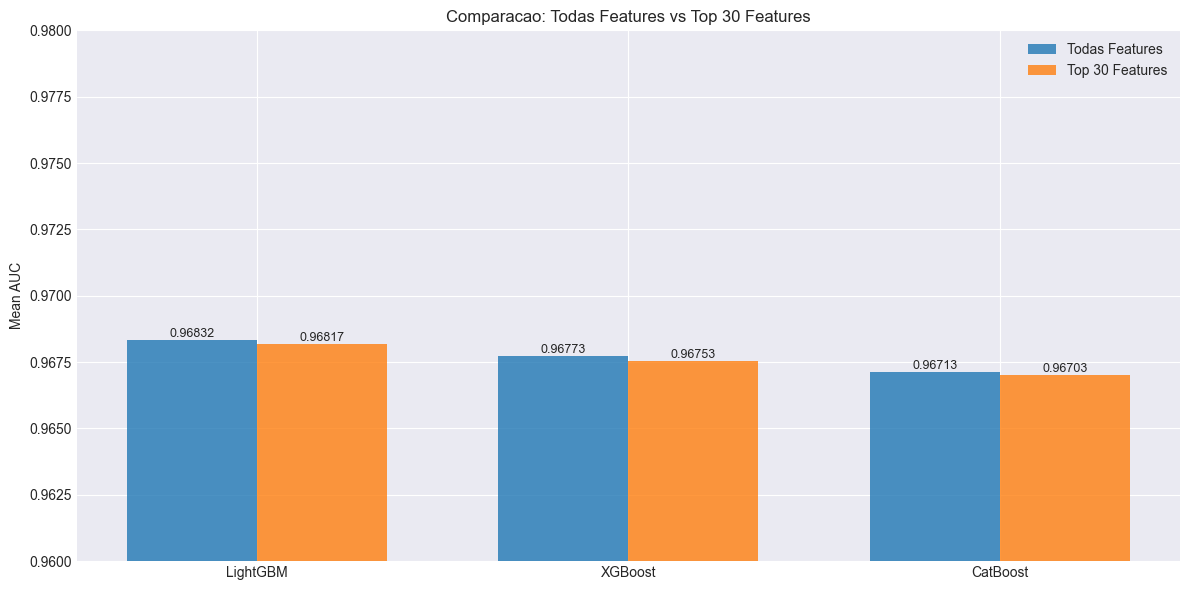


DECISAO: Qual conjunto de features usar no ensemble?

Media AUC (Todas features): 0.96773
Media AUC (Top 30 features): 0.96757
Diferenca: -0.00015

CONCLUSAO: Todas as features apresentam melhor performance!
Usaremos todas as features no ensemble final.


In [18]:
print("="*70)
print("ANALISE: TODAS FEATURES VS TOP 30 FEATURES")
print("="*70 + "\n")

# Carregar feature importance
top_n = 30
top_features = feature_importance.head(top_n)['feature'].tolist()

print(f"Top {top_n} features selecionadas:")
print(top_features)
print()

# Datasets com features selecionadas
X_selected = X[top_features]
X_test_selected = X_test[top_features]


# ===== LIGHTGBM: Todas vs Top 30 =====
print("\n" + "-"*70)
print("LIGHTGBM: Comparacao Todas Features vs Top 30")
print("-"*70)

lgb_top_scores = []
lgb_top_models = []

for fold, (train_idx, val_idx) in enumerate(skf.split(X_selected, y), 1):
    X_train_fold = X_selected.iloc[train_idx]
    X_val_fold = X_selected.iloc[val_idx]
    y_train_fold = y.iloc[train_idx]
    y_val_fold = y.iloc[val_idx]
    
    train_data = lgb.Dataset(X_train_fold, label=y_train_fold)
    val_data = lgb.Dataset(X_val_fold, label=y_val_fold, reference=train_data)
    
    model = lgb.train(
        lgb_best_params,
        train_data,
        num_boost_round=2000,
        valid_sets=[val_data],
        callbacks=[lgb.early_stopping(50, verbose=False)]
    )
    
    y_pred = model.predict(X_val_fold, num_iteration=model.best_iteration)
    auc = roc_auc_score(y_val_fold, y_pred)
    lgb_top_scores.append(auc)
    lgb_top_models.append(model)
    
    print(f"Fold {fold} AUC (top {top_n}): {auc:.5f}")

lgb_top_mean = np.mean(lgb_top_scores)
lgb_top_std = np.std(lgb_top_scores)

print(f"\nLightGBM - Todas features:  {lgb_tuned_mean_auc:.5f} (+/- {lgb_tuned_std_auc:.5f})")
print(f"LightGBM - Top {top_n} features: {lgb_top_mean:.5f} (+/- {lgb_top_std:.5f})")
print(f"Diferenca: {lgb_top_mean - lgb_tuned_mean_auc:.5f}")


# ===== XGBOOST: Todas vs Top 30 =====
print("\n" + "-"*70)
print("XGBOOST: Comparacao Todas Features vs Top 30")
print("-"*70)

xgb_top_scores = []
xgb_top_models = []

for fold, (train_idx, val_idx) in enumerate(skf.split(X_selected, y), 1):
    X_train_fold = X_selected.iloc[train_idx]
    X_val_fold = X_selected.iloc[val_idx]
    y_train_fold = y.iloc[train_idx]
    y_val_fold = y.iloc[val_idx]
    
    model = xgb.XGBClassifier(**xgb_best_params)
    model.fit(
        X_train_fold, y_train_fold,
        eval_set=[(X_val_fold, y_val_fold)],
        verbose=False
    )
    
    y_pred = model.predict_proba(X_val_fold)[:, 1]
    auc = roc_auc_score(y_val_fold, y_pred)
    xgb_top_scores.append(auc)
    xgb_top_models.append(model)
    
    print(f"Fold {fold} AUC (top {top_n}): {auc:.5f}")

xgb_top_mean = np.mean(xgb_top_scores)
xgb_top_std = np.std(xgb_top_scores)

print(f"\nXGBoost - Todas features:  {xgb_tuned_mean_auc:.5f} (+/- {xgb_tuned_std_auc:.5f})")
print(f"XGBoost - Top {top_n} features: {xgb_top_mean:.5f} (+/- {xgb_top_std:.5f})")
print(f"Diferenca: {xgb_top_mean - xgb_tuned_mean_auc:.5f}")


# ===== CATBOOST: Todas vs Top 30 =====
print("\n" + "-"*70)
print("CATBOOST: Comparacao Todas Features vs Top 30")
print("-"*70)

cat_top_scores = []
cat_top_models = []

for fold, (train_idx, val_idx) in enumerate(skf.split(X_selected, y), 1):
    X_train_fold = X_selected.iloc[train_idx]
    X_val_fold = X_selected.iloc[val_idx]
    y_train_fold = y.iloc[train_idx]
    y_val_fold = y.iloc[val_idx]
    
    model = CatBoostClassifier(**cat_best_params)
    model.fit(
        X_train_fold, y_train_fold,
        eval_set=(X_val_fold, y_val_fold),
        early_stopping_rounds=50,
        verbose=False
    )
    
    y_pred = model.predict_proba(X_val_fold)[:, 1]
    auc = roc_auc_score(y_val_fold, y_pred)
    cat_top_scores.append(auc)
    cat_top_models.append(model)
    
    print(f"Fold {fold} AUC (top {top_n}): {auc:.5f}")

cat_top_mean = np.mean(cat_top_scores)
cat_top_std = np.std(cat_top_scores)

print(f"\nCatBoost - Todas features:  {cat_tuned_mean_auc:.5f} (+/- {cat_tuned_std_auc:.5f})")
print(f"CatBoost - Top {top_n} features: {cat_top_mean:.5f} (+/- {cat_top_std:.5f})")
print(f"Diferenca: {cat_top_mean - cat_tuned_mean_auc:.5f}")


# ===== RESUMO DA COMPARACAO =====
print("\n" + "="*70)
print("RESUMO: TODAS FEATURES VS TOP 30")
print("="*70 + "\n")

comparison_features = pd.DataFrame([
    {'Model': 'LightGBM', 
     'Todas Features': f"{lgb_tuned_mean_auc:.5f}", 
     f'Top {top_n} Features': f"{lgb_top_mean:.5f}",
     'Diferenca': f"{lgb_top_mean - lgb_tuned_mean_auc:.5f}"},
    {'Model': 'XGBoost', 
     'Todas Features': f"{xgb_tuned_mean_auc:.5f}", 
     f'Top {top_n} Features': f"{xgb_top_mean:.5f}",
     'Diferenca': f"{xgb_top_mean - xgb_tuned_mean_auc:.5f}"},
    {'Model': 'CatBoost', 
     'Todas Features': f"{cat_tuned_mean_auc:.5f}", 
     f'Top {top_n} Features': f"{cat_top_mean:.5f}",
     'Diferenca': f"{cat_top_mean - cat_tuned_mean_auc:.5f}"}
])

print(comparison_features.to_string(index=False))

# Visualizar comparacao
fig, ax = plt.subplots(figsize=(12, 6))
x = np.arange(len(['LightGBM', 'XGBoost', 'CatBoost']))
width = 0.35

todas_features = [lgb_tuned_mean_auc, xgb_tuned_mean_auc, cat_tuned_mean_auc]
top_features_scores = [lgb_top_mean, xgb_top_mean, cat_top_mean]

bars1 = ax.bar(x - width/2, todas_features, width, label='Todas Features', alpha=0.8)
bars2 = ax.bar(x + width/2, top_features_scores, width, label=f'Top {top_n} Features', alpha=0.8)

ax.set_ylabel('Mean AUC')
ax.set_title('Comparacao: Todas Features vs Top 30 Features')
ax.set_xticks(x)
ax.set_xticklabels(['LightGBM', 'XGBoost', 'CatBoost'])
ax.legend()
ax.set_ylim(0.96, 0.98)

# Adicionar valores nas barras
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.5f}',
                ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

# Decisao: usar todas features ou top 30?
print("\n" + "="*70)
print("DECISAO: Qual conjunto de features usar no ensemble?")
print("="*70)

# Calcular media dos 3 modelos
mean_all_features = np.mean([lgb_tuned_mean_auc, xgb_tuned_mean_auc, cat_tuned_mean_auc])
mean_top_features = np.mean([lgb_top_mean, xgb_top_mean, cat_top_mean])

print(f"\nMedia AUC (Todas features): {mean_all_features:.5f}")
print(f"Media AUC (Top {top_n} features): {mean_top_features:.5f}")
print(f"Diferenca: {mean_top_features - mean_all_features:.5f}")

if mean_top_features > mean_all_features:
    print(f"\nCONCLUSAO: Top {top_n} features apresentam melhor performance!")
    print(f"Usaremos top {top_n} features no ensemble final.")
    use_top_features = True
else:
    print(f"\nCONCLUSAO: Todas as features apresentam melhor performance!")
    print(f"Usaremos todas as features no ensemble final.")
    use_top_features = False

## Ensemble com top 30 features

In [19]:
print("\n" + "="*70)
print("ENSEMBLE COM TOP 30 FEATURES")
print("="*70 + "\n")

# Treinar todos os modelos otimizados com top 30 features
ensemble_lgb_models = []
ensemble_xgb_models = []
ensemble_cat_models = []
ensemble_scores = []

for fold, (train_idx, val_idx) in enumerate(skf.split(X_selected, y), 1):
    print(f"\nTraining Ensemble Fold {fold}/{N_FOLDS}")
    
    X_train_fold = X_selected.iloc[train_idx]
    X_val_fold = X_selected.iloc[val_idx]
    y_train_fold = y.iloc[train_idx]
    y_val_fold = y.iloc[val_idx]
    
    # LightGBM
    train_data = lgb.Dataset(X_train_fold, label=y_train_fold)
    val_data = lgb.Dataset(X_val_fold, label=y_val_fold, reference=train_data)
    lgb_model = lgb.train(
        lgb_best_params,
        train_data,
        num_boost_round=2000,
        valid_sets=[val_data],
        callbacks=[lgb.early_stopping(50, verbose=False)]
    )
    
    # XGBoost
    xgb_model = xgb.XGBClassifier(**xgb_best_params)
    xgb_model.fit(
        X_train_fold, y_train_fold,
        eval_set=[(X_val_fold, y_val_fold)],
        verbose=False
    )
    
    # CatBoost
    cat_model = CatBoostClassifier(**cat_best_params)
    cat_model.fit(
        X_train_fold, y_train_fold,
        eval_set=(X_val_fold, y_val_fold),
        early_stopping_rounds=50,
        verbose=False
    )
    
    # Predicoes
    lgb_pred = lgb_model.predict(X_val_fold, num_iteration=lgb_model.best_iteration)
    xgb_pred = xgb_model.predict_proba(X_val_fold)[:, 1]
    cat_pred = cat_model.predict_proba(X_val_fold)[:, 1]
    
    # Ensemble: media simples
    ensemble_pred = (lgb_pred + xgb_pred + cat_pred) / 3
    
    auc = roc_auc_score(y_val_fold, ensemble_pred)
    ensemble_scores.append(auc)
    
    ensemble_lgb_models.append(lgb_model)
    ensemble_xgb_models.append(xgb_model)
    ensemble_cat_models.append(cat_model)
    
    print(f"Fold {fold} Ensemble AUC: {auc:.5f}")

ensemble_mean_auc = np.mean(ensemble_scores)
ensemble_std_auc = np.std(ensemble_scores)

print(f"\n{'='*50}")
print(f"Ensemble Mean AUC: {ensemble_mean_auc:.5f} (+/- {ensemble_std_auc:.5f})")
print(f"{'='*50}\n")


ENSEMBLE COM TOP 30 FEATURES


Training Ensemble Fold 1/5
Fold 1 Ensemble AUC: 0.96888

Training Ensemble Fold 2/5
Fold 2 Ensemble AUC: 0.96799

Training Ensemble Fold 3/5
Fold 3 Ensemble AUC: 0.96764

Training Ensemble Fold 4/5
Fold 4 Ensemble AUC: 0.96883

Training Ensemble Fold 5/5
Fold 5 Ensemble AUC: 0.96813

Ensemble Mean AUC: 0.96829 (+/- 0.00049)



## Comparação Final

COMPARACAO FINAL DE TODOS OS MODELOS

              Model  Mean AUC  Std AUC
     LightGBM Tuned  0.968320 0.000458
  Ensemble (Top 30)  0.968292 0.000485
  LightGBM Baseline  0.967808 0.000443
      XGBoost Tuned  0.967734 0.000539
   XGBoost Baseline  0.967302 0.000531
     CatBoost Tuned  0.967133 0.000573
  CatBoost Baseline  0.965365 0.000442
Logistic Regression  0.935543 0.000837


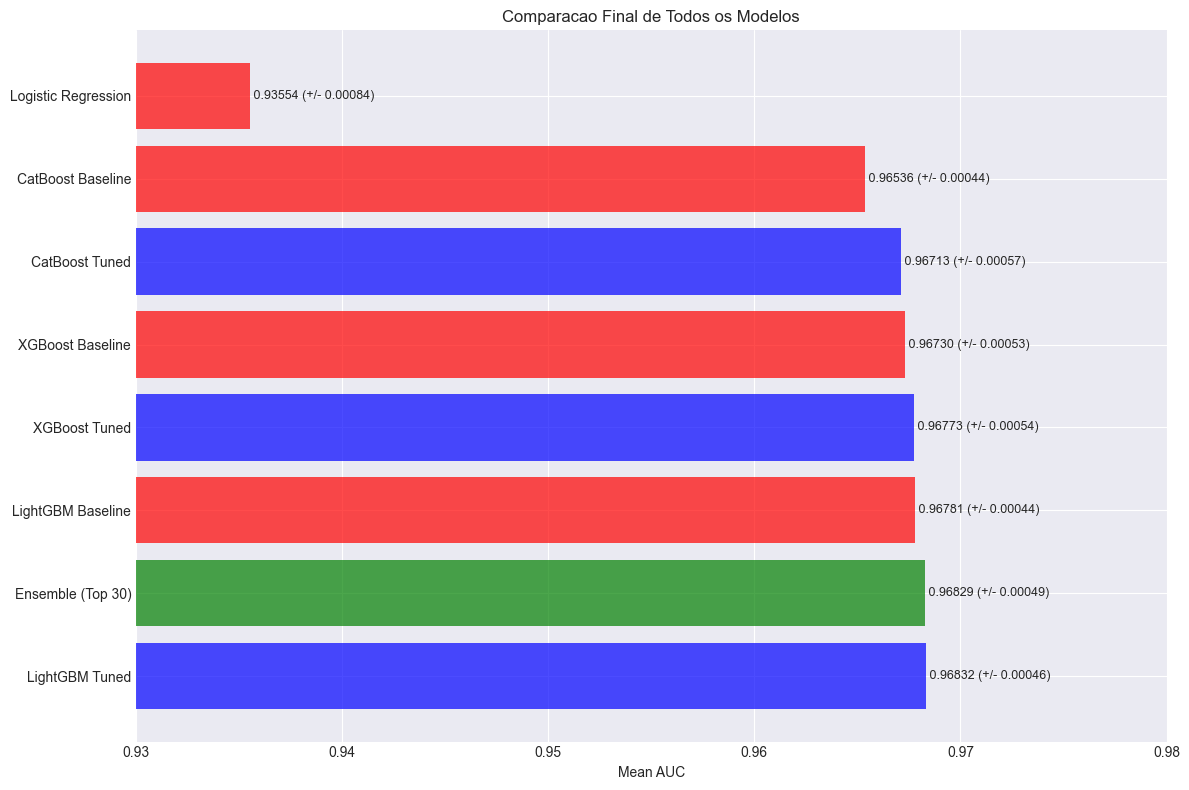

In [20]:
print("="*70)
print("COMPARACAO FINAL DE TODOS OS MODELOS")
print("="*70 + "\n")

final_comparison = pd.DataFrame([
    {'Model': 'Logistic Regression', 'Mean AUC': lr_mean_auc, 'Std AUC': lr_std_auc},
    {'Model': 'LightGBM Baseline', 'Mean AUC': lgb_mean_auc, 'Std AUC': lgb_std_auc},
    {'Model': 'XGBoost Baseline', 'Mean AUC': xgb_mean_auc, 'Std AUC': xgb_std_auc},
    {'Model': 'CatBoost Baseline', 'Mean AUC': cat_mean_auc, 'Std AUC': cat_std_auc},
    {'Model': 'LightGBM Tuned', 'Mean AUC': lgb_tuned_mean_auc, 'Std AUC': lgb_tuned_std_auc},
    {'Model': 'XGBoost Tuned', 'Mean AUC': xgb_tuned_mean_auc, 'Std AUC': xgb_tuned_std_auc},
    {'Model': 'CatBoost Tuned', 'Mean AUC': cat_tuned_mean_auc, 'Std AUC': cat_tuned_std_auc},
    {'Model': 'Ensemble (Top 30)', 'Mean AUC': ensemble_mean_auc, 'Std AUC': ensemble_std_auc}
])

final_comparison = final_comparison.sort_values('Mean AUC', ascending=False)
print(final_comparison.to_string(index=False))

# Visualizar comparacao final
plt.figure(figsize=(12, 8))
colors = ['red' if 'Baseline' in m or 'Logistic' in m else 'green' if 'Ensemble' in m else 'blue' 
          for m in final_comparison['Model']]
plt.barh(final_comparison['Model'], final_comparison['Mean AUC'], color=colors, alpha=0.7)
plt.xlabel('Mean AUC')
plt.title('Comparacao Final de Todos os Modelos')
plt.xlim(0.93, 0.98)
for i, (auc, std) in enumerate(zip(final_comparison['Mean AUC'], final_comparison['Std AUC'])):
    plt.text(auc, i, f' {auc:.5f} (+/- {std:.5f})', va='center', fontsize=9)
plt.tight_layout()
plt.show()

# Salvandos modelos e resultados

In [ ]:
print("\n" + "="*70)
print("SALVANDO MODELOS E RESULTADOS")
print("="*70 + "\n")

# Salvar modelos do ensemble
joblib.dump(ensemble_lgb_models, '../models/ensemble_lgb_models_gpu.pkl')
joblib.dump(ensemble_xgb_models, '../models/ensemble_xgb_models_gpu.pkl')
joblib.dump(ensemble_cat_models, '../models/ensemble_cat_models_gpu.pkl')

# Salvar top features
with open('../data/processed/top_30_features.txt', 'w') as f:
    for feature in top_features:
        f.write(f"{feature}\n")

# Salvar comparacao final
final_comparison.to_csv('../data/processed/final_model_comparison_gpu.csv', index=False)

print("Modelos e resultados salvos com sucesso!")
print("\nArquivos salvos:")
print("  - ../models/ensemble_lgb_models_gpu.pkl")
print("  - ../models/ensemble_xgb_models_gpu.pkl")
print("  - ../models/ensemble_cat_models_gpu.pkl")
print("  - ../data/processed/top_30_features.txt")
print("  - ../data/processed/final_model_comparison_gpu.csv")

print("\n" + "="*70)
print("MODELAGEM COMPLETA!")
print("="*70)